## **CENÁRIO 03: COMPLETO** 

IMPORTS

In [215]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas


### **ETAPA 1 - Obtendo informações de tempo do Yamazumi**

In [216]:
# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

In [217]:

# --- Dicionários ---
#Adaptação para o cenário 3
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": [1,2], "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951501", "C951511", "C951514", "C951530", "C951544"],"perna": [1,2], "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": [1,2], "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": [1,2], "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": [1,2], "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":[1,2], "tempos": "Yamazumi - Actros.csv"}
}

ATIVIDADES = { 'PASSADISASSO':{'postos':['30B','30A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ABASTECIMENTO':{'postos':['31B','31A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'CHINELEIRA':{'postos':['32B','32A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                '5AA_RODA': {'postos':['32D','32C'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'PNEU_LD':{'postos':['33B','33A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1}, 
                'PNEU_LE':{'postos':['33B','33A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'PARALAMA_LD': {'postos':['34B','34A'],'modelos':['Actros','Arocs', 'Axor (ATP +)',"Accelo", "Atego", "Atego (ATP)"],'operadores':1},#mesmo operador que o de aperto_ld e le
                'PARALAMA_LE':{'postos':['34B','34A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'CONTROLE': {'postos':['34B','34A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ELACTRICA_I':{'postos':['33B','34B','39','33A','34A','38'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ELACTRICA_II':{'postos':['33B','34B','39','33A','34A','38'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ELACTRICA_III':{'postos':['33B','34B','39','33A','34A','38'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':0},
                
                #Atividades da p1 que foram para a p2
                'DIESEL':{'postos':['30B','30A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ARREFEC':{'postos':['31B','31A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'REAPERTO':{'postos':['32B','32A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ESTEPE':{'postos':['32D','32C'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'APERTO_LE':{'postos':['32D','32C'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'APERTO_LD':{'postos':['34B','34A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'GRADE':{'postos':['34B','34A'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'MECACNICA_1':{'postos':['34A','38','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'MECACNICA_2':{'postos':['34A','38','34A','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ELACTRICA_1':{'postos':['32A','32C','33A','32B','32D','33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'ELACTRICA_2':{'postos':['32A','32C','33A','32B','32D','33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'MOTORISTA':{'postos':['38','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
                'QUIS':{'postos':['38','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego','Atego (ATP)'],'operadores':1},
        }


In [218]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv):
    """
    Para cada modelo:
      - Calcula os tempos nos postos da PERNA 1 (30A,31A,32A,32C,33A,34A,38)
        seguindo as fórmulas já estabelecidas (sempre dividindo por 'operadores' antes).
      - ESPELHA os tempos para a PERNA 2:
        30B=30A, 31B=31A, 32B=32A, 32D=32C, 33B=33A, 34B=34A, 39=38.
      - Retorna um único dicionário por modelo contendo **todos os postos A e B**.
    """

    ordem_A = ['30A','31A','32A','32C','33A','34A','38']
    pares_AB = {
        '30A':'30B', '31A':'31B', '32A':'32B',
        '32C':'32D', '33A':'33B', '34A':'34B', '38':'39'
    }

    POSTOS = {}

    # ----------------- Helpers -----------------
    def model_usa(atividade, modelo_nome):
        try:
            return modelo_nome in ATIVIDADES[atividade]['modelos']
        except Exception:
            return False

    def atividade_prevista_no_posto(atividade, posto):
        try:
            return posto in ATIVIDADES[atividade]['postos']
        except Exception:
            return False

    def t_activity(atividade, tempos, modelo_nome):
        """tempo/operadores (0 se atividade não existe, modelo não usa, ou ops==0)."""
        if atividade not in ATIVIDADES:
            return 0.0
        if not model_usa(atividade, modelo_nome):
            return 0.0
        ops = ATIVIDADES[atividade].get('operadores', 1) or 1
        return (tempos.get(atividade, 0.0)) / ops

    def t_in_posto(atividade, posto, tempos, modelo_nome):
        """tempo/operadores **somente** se o posto constar para a atividade."""
        if not atividade_prevista_no_posto(atividade, posto):
            return 0.0
        return t_activity(atividade, tempos, modelo_nome)

    def avg(vals):
        vals = [v for v in vals if v is not None]
        return (sum(vals) / len(vals)) if vals else 0.0
    # -------------------------------------------

    for modelo, dados in MODELOS_CSV.items():
        tempos = get_process_times_from_csv(dados["tempos"])
        if not tempos:
            continue

        # ---------- PERNA 1 (A) ----------
        p_30A = t_in_posto('DIESEL', '30A', tempos, modelo)
        p_31A = t_in_posto('ARREFEC', '31A', tempos, modelo)

        # elétricas auxiliares P1: (EL1/op + EL2/op)/2/3
        el_mix_p1 = avg([
            t_activity('ELACTRICA_1', tempos, modelo),
            t_activity('ELACTRICA_2', tempos, modelo)
        ]) / 3.0

        # 32A = REAPERTO/op + el_mix_p1
        p_32A = t_in_posto('REAPERTO', '32A', tempos, modelo) + el_mix_p1

        # 32C = ESTEPE/op + avg(APERTO_LE/op, 5AA_RODA/op) + el_mix_p1
        p_32C = (
            t_in_posto('ESTEPE', '32C', tempos, modelo) +
            avg([
                t_in_posto('APERTO_LE', '32C', tempos, modelo),
                t_in_posto('5AA_RODA', '32C', tempos, modelo),
            ]) +
            el_mix_p1
        )

        # 33A = avg(PNEU_LE/op, PNEU_LD/op) + el_mix_p1
        pneus_A = avg([
            t_in_posto('PNEU_LE', '33A', tempos, modelo),
            t_in_posto('PNEU_LD', '33A', tempos, modelo),
        ])
        p_33A = pneus_A + el_mix_p1

        # 34A = APERTO_LD/op + GRADE/op + avg(MEC1/op, MEC2/op)/2
        mec_avg_A = avg([
            t_in_posto('MECACNICA_1', '34A', tempos, modelo),
            t_in_posto('MECACNICA_2', '34A', tempos, modelo),
        ]) / 2.0
        p_34A = (
            t_in_posto('APERTO_LD', '34A', tempos, modelo) +
            t_in_posto('GRADE', '34A', tempos, modelo) +
            mec_avg_A
        )

        # 38 = MOTORISTA/op + QUIS/op + avg(MEC1/op, MEC2/op)/2
        p_38 = (
            t_in_posto('MOTORISTA', '38', tempos, modelo) +
            t_in_posto('QUIS', '38', tempos, modelo) +
            mec_avg_A
        )

        tempos_A = {
            '30A': p_30A, '31A': p_31A, '32A': p_32A, '32C': p_32C,
            '33A': p_33A, '34A': p_34A, '38': p_38
        }

        # ---------- ESPELHO PARA PERNA 2 (B) ----------
        postos_ordenados = {}

        # inclui todos A (perna [1])
        for postoA in ordem_A:
            v = float(tempos_A.get(postoA, 0.0)) if tempos_A.get(postoA, 0.0) else 0.0
            if v > 0:
                postos_ordenados[postoA] = {"tempo_tot": v, "perna": [1]}

        # cria pares B com o mesmo valor de A (perna [2])
        for postoA, postoB in pares_AB.items():
            v = float(tempos_A.get(postoA, 0.0)) if tempos_A.get(postoA, 0.0) else 0.0
            if v > 0:
                postos_ordenados[postoB] = {"tempo_tot": v, "perna": [2]}

        POSTOS[modelo] = postos_ordenados

    return POSTOS


In [219]:
POSTOS= gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv)

In [220]:
POSTOS

{'Accelo': {'30A': {'tempo_tot': 253.0, 'perna': [1]},
  '31A': {'tempo_tot': 316.0, 'perna': [1]},
  '32A': {'tempo_tot': 354.0, 'perna': [1]},
  '32C': {'tempo_tot': 561.0, 'perna': [1]},
  '33A': {'tempo_tot': 369.0, 'perna': [1]},
  '34A': {'tempo_tot': 671.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]},
  '30B': {'tempo_tot': 253.0, 'perna': [2]},
  '31B': {'tempo_tot': 316.0, 'perna': [2]},
  '32B': {'tempo_tot': 354.0, 'perna': [2]},
  '32D': {'tempo_tot': 561.0, 'perna': [2]},
  '33B': {'tempo_tot': 369.0, 'perna': [2]},
  '34B': {'tempo_tot': 671.0, 'perna': [2]},
  '39': {'tempo_tot': 633.0, 'perna': [2]}},
 'Atego': {'30A': {'tempo_tot': 314.0, 'perna': [1]},
  '31A': {'tempo_tot': 314.0, 'perna': [1]},
  '32A': {'tempo_tot': 414.0, 'perna': [1]},
  '32C': {'tempo_tot': 544.5, 'perna': [1]},
  '33A': {'tempo_tot': 428.0, 'perna': [1]},
  '34A': {'tempo_tot': 646.0, 'perna': [1]},
  '38': {'tempo_tot': 633.0, 'perna': [1]},
  '30B': {'tempo_tot': 314.0, 'perna':

### ETAPA 03: Processamento da simulação 

In [221]:
TAKT_TIME = 5.5 * 60

TURN_DURATION = 14 * 3600
 
# defina a granularidade (1.0 = segundos; use 0.1 p/ décimos, 0.01 p/ centésimos)

TIME_GRID = 1.0
 
def q(t, base=TIME_GRID):

    # alinha t para a grade de tempo definida

    return round(t / base) * base
 
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos, log):

    for idx, (posto, dados) in enumerate(postos_dict.items()):

        tempo_tot = float(dados["tempo_tot"])

        recurso = recursos[posto]
 
        # requisita recurso

        req = recurso.request()

        instante_requisicao = env.now

        yield req
 
        # início real no posto (após obter o recurso), já quantizado

        inicio = q(env.now)

        tempo_proc = q(tempo_tot)
 
        # executa processamento com tempo quantizado

        yield env.timeout(tempo_proc)

        fim = q(env.now)
 
        # libera o recurso explicitamente

        recurso.release(req)
 
        # registra

        log.append({

            "modelo": modelo_nome,

            "nome": nome,

            "posto": posto,

            "perna": perna,

            "fila": max(0.0, inicio - q(instante_requisicao)),  # espera antes de iniciar

            "processo": tempo_proc,                              # tempo de posto (sem fila)

            "entrada": inicio,                                   # início no posto

            "saida": fim,                                        # fim no posto

            "duracao": fim - inicio                              # deve == tempo_proc (dentro da grade)

        })

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
    env = simpy.Environment()

    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']

    log_entrada_saida = []

    # recursos por posto (inalterado)
    recursos = {}
    for modelo in resultado.values():
        for posto in modelo.keys():
            if posto not in recursos:
                recursos[posto] = simpy.Resource(env, capacity=1)

    ultimo_tempo_entrada_global = 0.0
    disponibilidade_postos = {}

    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # alternador 1→2→1→2...
        next_perna = 1

        for i, baumuster in enumerate(sequencia_modelos):
            # 1) resolve o modelo pelo baumuster
            modelo_nome = None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    break
            if modelo_nome is None:
                # não alterna se não encontrou o modelo
                continue

            # 2) perna definida estritamente pela alternância
            perna = next_perna
            next_perna = 2 if next_perna == 1 else 1  # já alterna para o próximo da fila

            # 3) filtra os postos do modelo para a perna escolhida
            if modelo_nome not in resultado:
                continue
            modelo_dict = resultado[modelo_nome]
            postos_filtrados = {p: d for p, d in modelo_dict.items() if perna in d.get("perna", [])}
            if not postos_filtrados:
                # se por algum motivo não houver postos nessa perna, pula (e a alternância já ficou pronta para o próximo)
                continue

            # 4) ordena os postos conforme a perna
            ordem = ordem_P1 if perna == 1 else ordem_P2
            postos_dict = {p: postos_filtrados[p] for p in ordem if p in postos_filtrados}
            if not postos_dict:
                continue

            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = float(postos_dict[primeiro_posto]["tempo_tot"])

            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0.0

            # 5) agenda a entrada respeitando takt, disponibilidade do 1º posto e grade
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = q(max(env.now,
                                     ultimo_tempo_entrada_global + TAKT_TIME,
                                     tempo_disponivel_posto))
            atraso = max(0.0, entrada_sugerida - env.now)
            if atraso:
                yield env.timeout(atraso)

            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = q(entrada_sugerida + tempo_ciclo_primeiro_posto)

            # 6) dispara o processo
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos,
                log=log_entrada_saida
            ))

    env.process(alimentador(env))
    env.run(until=q(TURN_DURATION))

    df = pd.DataFrame(log_entrada_saida)
    for col in ["fila", "processo", "entrada", "saida", "duracao"]:
        if col in df.columns:
            df[col] = df[col].apply(q)
    return df



### ETAPA 04 : Criando funções de resposta gráfica  

In [222]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [223]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(14, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [224]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)
    print(modelos_produzidos)

    fig, ax = plt.subplots(figsize=(15, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [225]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):
    env = simpy.Environment()

    log_entrada_saida = []

    # ordem de postos por perna (para escolher o primeiro posto correto)
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']

    # recursos por posto (igual)
    recursos = {}
    for modelo in resultado.values():
        for posto in modelo.keys():
            if posto not in recursos:
                recursos[posto] = simpy.Resource(env, capacity=1)

    ultimo_tempo_entrada_global = 0.0
    disponibilidade_postos = {}

    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        for i, baumuster in enumerate(sequencia_modelos):

            # resolve o nome do modelo
            modelo_nome = None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    break
            if modelo_nome is None:
                continue

            # *** alternância rígida por posição na sequência ***
            perna = 1 if (i % 2 == 0) else 2

            # pega o dicionário completo do modelo e filtra só a perna escolhida
            if modelo_nome not in resultado:
                continue
            modelo_dict = resultado[modelo_nome]
            postos_dict = {p: d for p, d in modelo_dict.items() if perna in d.get("perna", [])}
            if not postos_dict:
                continue

            # escolhe o primeiro posto pela ordem da perna
            ordem = ordem_P1 if perna == 1 else ordem_P2
            primeiro_posto = next((p for p in ordem if p in postos_dict), None)
            if primeiro_posto is None:
                continue

            tempo_ciclo_primeiro_posto = float(postos_dict[primeiro_posto]["tempo_tot"])
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0.0

            # agenda a entrada (mantido)
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = q(max(env.now,
                                     ultimo_tempo_entrada_global + TAKT_TIME,
                                     tempo_disponivel_posto))
            atraso = max(0.0, entrada_sugerida - env.now)
            if atraso:
                yield env.timeout(atraso)

            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = q(entrada_sugerida + tempo_ciclo_primeiro_posto)

            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos,
                log=log_entrada_saida
            ))

    env.process(alimentador(env))
    env.run(until=q(TURN_DURATION))

    df = pd.DataFrame(log_entrada_saida)
    for col in ["fila", "processo", "entrada", "saida", "duracao"]:
        if col in df.columns:
            df[col] = df[col].apply(q)
    return df


In [226]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    print(modelos_completos)

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [227]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [228]:
#GRÁFICO ESPECIAL INDEPENDE DE DFLOG
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    figs =[]
    
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5
        
        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        figs.append(fig)

    return figs 

def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv):
    """
    Gera, para cada modelo, gráficos de barras do tempo por atividade,
    um para a rota da Perna 1 e outro para a rota da Perna 2.
    """
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    figs = []

    # 1. Itera sobre cada modelo definido
    for modelo, props in MODELOS_CSV.items():
        arquivo = props["tempos"]
        tempos_atividade_modelo = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade_modelo:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        # 2. Para cada modelo, cria um gráfico para cada perna potencial
        for perna in [1, 2]:
            lista_dados_perna = []
            atividades_da_perna = {
                nome.replace(f'_P{perna}', ''): dados 
                for nome, dados in ATIVIDADES.items() 
                if f'_P{perna}' in nome
            }

            # 3. Coleta os dados das atividades que o modelo realiza na perna atual
            for atividade, dados_atividade in atividades_da_perna.items():
                if atividade in tempos_atividade_modelo:
                    tempo_total = tempos_atividade_modelo.get(atividade, 0)
                    tempo_por_operador = tempo_total / dados_atividade["operadores"] if dados_atividade["operadores"] > 0 else 0
                    
                    for posto in dados_atividade["postos"]:
                        lista_dados_perna.append({
                            "modelo": modelo,
                            "atividade": atividade,
                            "posto": posto,
                            "tempo_min": tempo_por_operador / 60,
                            "perna": perna
                        })
            
            # Se não houver atividades para este modelo nesta perna, pula para a próxima
            if not lista_dados_perna:
                continue

            df_modelo_perna = pd.DataFrame(lista_dados_perna)
            
            # 4. Ordena e plota o gráfico
            ordem = ordem_P1 if perna == 1 else ordem_P2
            df_modelo_perna["ordem_posto"] = df_modelo_perna["posto"].apply(lambda p: ordem.index(p) if p in ordem else -1)
            df_modelo_perna = df_modelo_perna.sort_values(["ordem_posto", "atividade"])

            linha_meta = 5.5  # Pode ajustar as metas se forem diferentes
            
            fig, ax = plt.subplots(figsize=(20, 9))
            sns.barplot(data=df_modelo_perna, x="atividade", y="tempo_min", hue="posto", dodge=False, ax=ax)
            ax.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
            
            # Título mais específico
            ax.set_title(f"Tempo por Atividade - {modelo} (Simulando na Perna {perna})")
            ax.set_xlabel("Atividade")
            ax.set_ylabel("Tempo por posto (minutos)")
            ax.tick_params(axis='x', rotation=45)
            ax.legend()
            fig.tight_layout()
            
            # Em vez de plt.show(), apenas salvamos a figura para uso posterior
            figs.append(fig)

    return figs


Resumo da simulação em pdf

In [229]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    """

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")

    linhas.append("\nTempo médio de produção por modelo:")
    for perna, tempo in tempo_medio_producao.items():
        linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

    linhas.append("\nTakt time médio por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nNovo Takt time real (TURN_DURATION / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")



### ETAPA 05: Leitura das sequências e geração de resultados

In [230]:
def analisar_carga_trabalho_real(df_log, TURN_DURATION):
    """
    Calcula a carga de trabalho real (em operadores-médios) por perna
    com base nos resultados da simulação.
    """
    if df_log.empty:
        print("Log de simulação vazio, não é possível analisar a carga de trabalho.")
        return {} # Retorna um dicionário vazio se não houver dados

    # 1. Calcular o total de minutos de trabalho gastos em cada perna
    total_minutos_trabalho_por_perna = df_log.groupby('perna')['duracao'].sum() / 60

    # 2. Calcular o número médio de operadores que estiveram ocupados durante o turno
    # Carga de Trabalho = (Total de minutos de trabalho) / (Total de minutos disponíveis no turno)
    minutos_turno = TURN_DURATION / 60
    carga_media_operadores = (total_minutos_trabalho_por_perna / minutos_turno).to_dict()

    print(f"\n--- Análise de Carga de Trabalho (Resultado da Simulação) ---")
    for perna, carga in carga_media_operadores.items():
        print(f"Perna {int(perna)}: Carga de trabalho equivalente a {carga:.2f} operadores trabalhando constantemente.")
    print("----------------------------------------------------------")
    
    return carga_media_operadores

🗓️ Dias selecionados (5 a partir de 2025-04-10):
  - 2025-04-10
  - 2025-04-11
  - 2025-04-14
  - 2025-04-15
  - 2025-04-16

🔄 Processando o dia: 2025-04-10
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
27081 2025-04-10 05:46:32    C96840312 1932        C968403
18513 2025-04-10 05:51:26       C9515011268        C951501
24924 2025-04-10 05:56:14  C9515011248 1719        C951501
16332 2025-04-10 06:04:04         C96341112        C963411
22819 2025-04-10 06:09:03  C9511041246 1117        C951104
31326 2025-04-10 06:16:03  C9511041239 1117        C951104
31327 2025-04-10 06:20:51       C9515111274        C951511
3345  2025-04-10 06:27:17    C96840312 1932        C968403
20691 2025-04-10 06:32:43  C9515011262 1732        C951501
31328 2025-04-10 06:41:28  C9515111248 2433        C951511


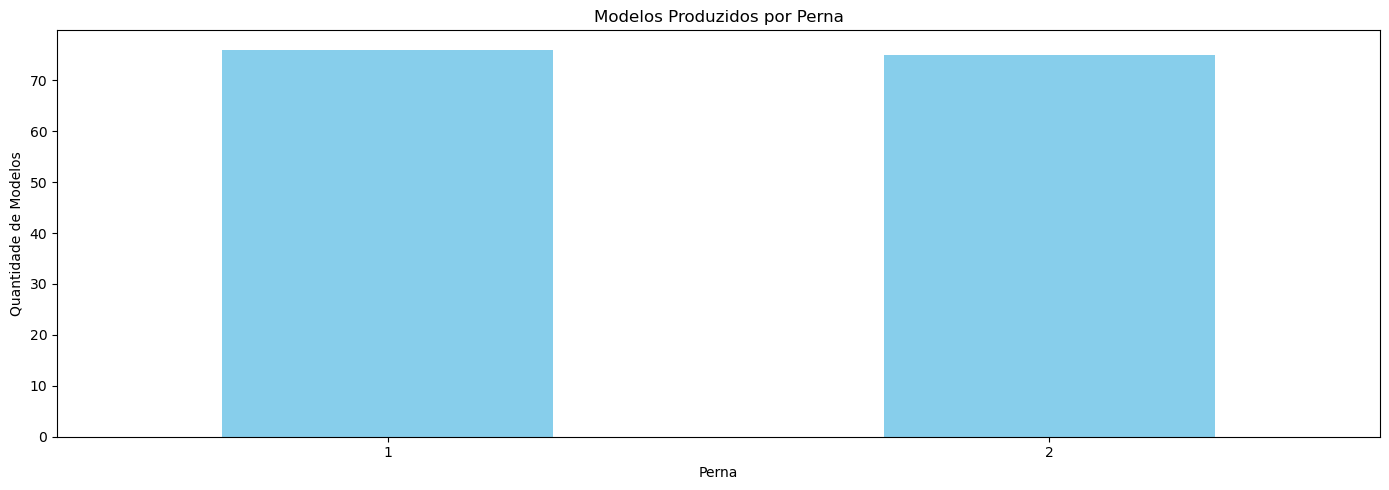

modelo
Atego          60
Accelo         40
Actros         27
Atego (ATP)    24
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_4128\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0    Accelo_106  Accelo      1        35310.0      38682.0
1    Accelo_111  Accelo      2        36960.0      40750.0
2    Accelo_112  Accelo      1        37290.0      40447.0
3    Accelo_114  Accelo      1        37950.0      41118.0
4    Accelo_120  Accelo      1        39930.0      43748.0
..          ...     ...    ...            ...          ...
146    Atego_84   Atego      1        28050.0      31343.0
147     Atego_9   Atego      2         3300.0       7574.0
148    Atego_90   Atego      1        30030.0      33599.0
149    Atego_93   Atego      2        31020.0      34824.0
150    Atego_97   Atego      2        32340.0      36141.0

[151 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_4128\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


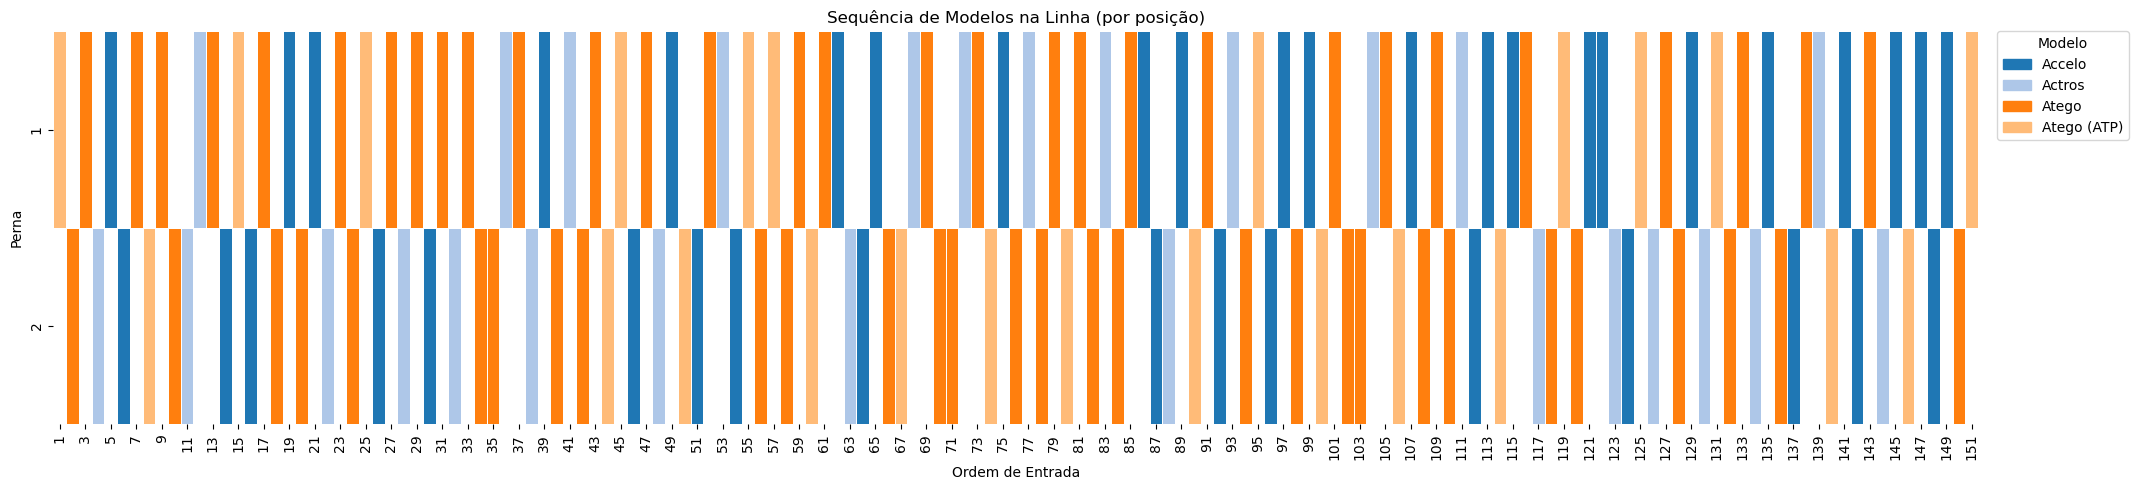

C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-10/log_2025-04-10.csv
📝 PDF salvo em: logs_C3/2025-04-10/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-11
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
12373 2025-04-11 05:50:36  C9511041239 1017        C951104
33740 2025-04-11 05:56:53  C9511041246 1017        C951104
27327 2025-04-11 06:01:18       C9515011268        C951501
3605  2025-04-11 06:06:30  C9515111248 2433        C951511
14525 2025-04-11 06:13:02  C9634241215 2651        C963424
16620 2025-04-11 06:17:48       C9515011268        C951501
3606  2025-04-11 06:26:00    C96840312 1932        C968403
10150 2025-04-11 06:31:03       C9515111274        C951511
3607  2025-04-11 06:36:02       C9515111274        C951511
33742 2025-04-11 06:41:02  C9511111246 1317        C951111


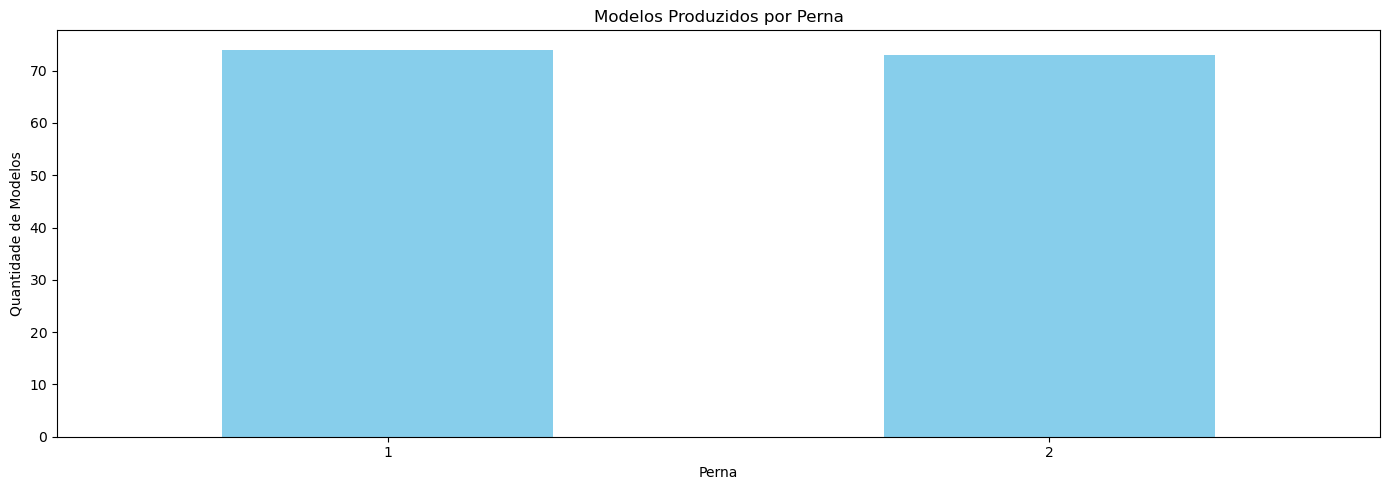

modelo
Atego           65
Accelo          36
Atego (ATP)     23
Actros          21
Arocs            1
Axor (ATP +)     1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_4128\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


                nome        modelo  perna  entrada_total  saida_total
0           Accelo_0        Accelo      1          330.0       3487.0
1           Accelo_1        Accelo      2          660.0       3817.0
2         Accelo_104        Accelo      1        34650.0      38468.0
3         Accelo_107        Accelo      2        35640.0      38797.0
4         Accelo_109        Accelo      2        36300.0      39468.0
..               ...           ...    ...            ...          ...
142         Atego_88         Atego      1        29370.0      33146.0
143         Atego_90         Atego      1        30030.0      33792.0
144         Atego_93         Atego      2        31020.0      34697.0
145         Atego_97         Atego      2        32340.0      36132.0
146  Axor (ATP +)_94  Axor (ATP +)      1        31616.0      32517.0

[147 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_4128\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


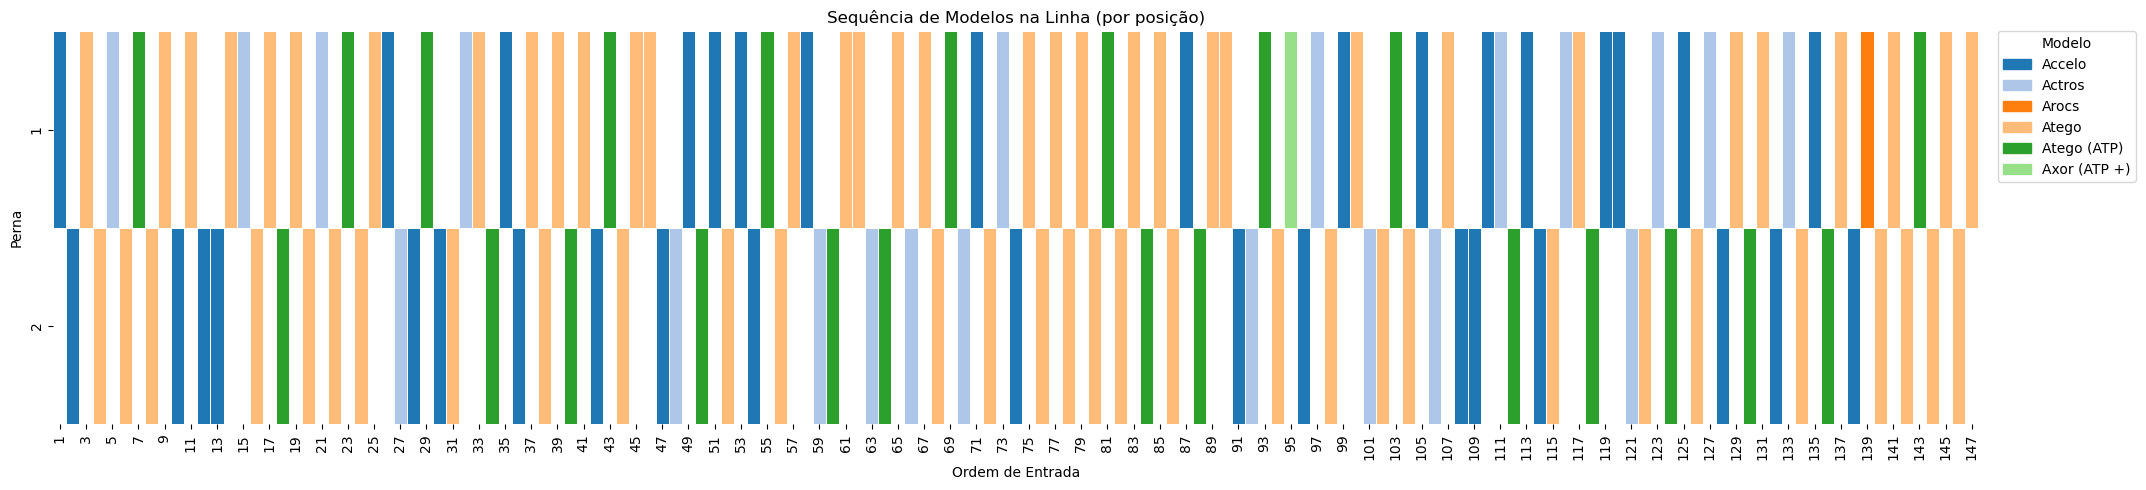

C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-11/log_2025-04-11.csv
📝 PDF salvo em: logs_C3/2025-04-11/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-14
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
25344 2025-04-14 05:47:26  C9511111239 1317        C951111
16788 2025-04-14 05:53:42    C96840312 1932        C968403
1589  2025-04-14 06:00:28  C9511041246 1017        C951104
8118  2025-04-14 06:08:05  C9634251233 2545        C963425
31732 2025-04-14 06:13:46  C9515011268 1726        C951501
27502 2025-04-14 06:18:59  C9511041246 1017        C951104
10296 2025-04-14 06:25:12    C96840312 1932        C968403
1415  2025-04-14 06:30:50  C9515011268 1721        C951501
16789 2025-04-14 06:37:22       C9515111274        C951511
16790 2025-04-14 06:46:54  C9511041239 1017        C951104


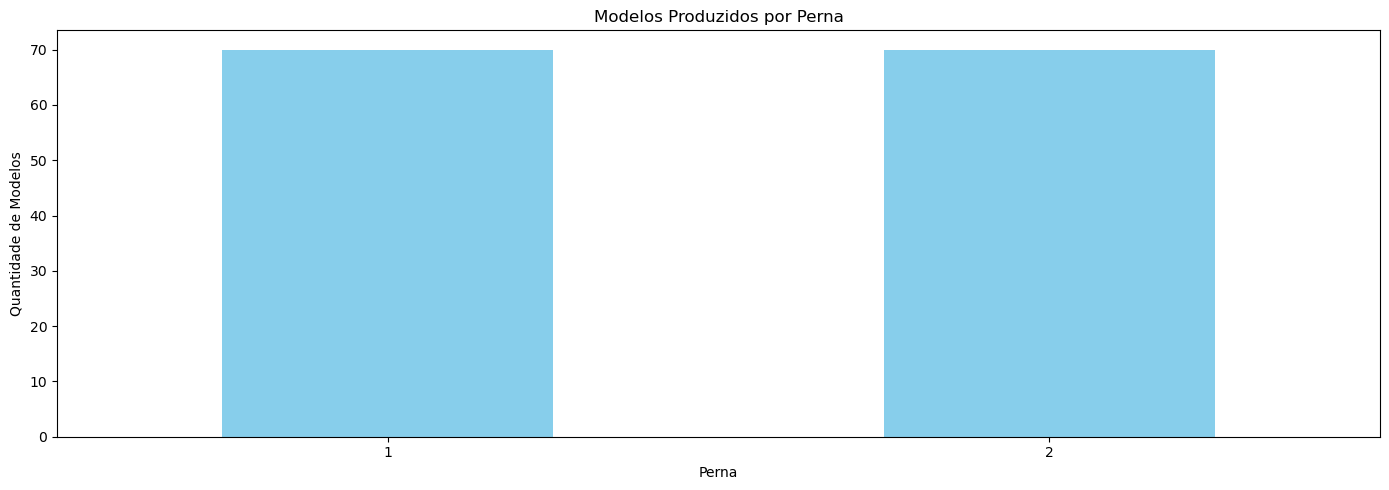

modelo
Atego          50
Accelo         42
Actros         25
Atego (ATP)    22
Arocs           1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_4128\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       3487.0
1     Accelo_10  Accelo      1         3630.0       7434.0
2    Accelo_103  Accelo      2        34320.0      37624.0
3    Accelo_107  Accelo      2        35640.0      39939.0
4     Accelo_11  Accelo      2         3960.0       7275.0
..          ...     ...    ...            ...          ...
135    Atego_87   Atego      2        29040.0      32333.0
136    Atego_89   Atego      2        29700.0      32993.0
137    Atego_92   Atego      1        30690.0      34257.0
138    Atego_94   Atego      1        31350.0      34903.0
139    Atego_97   Atego      2        32340.0      35909.0

[140 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_4128\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


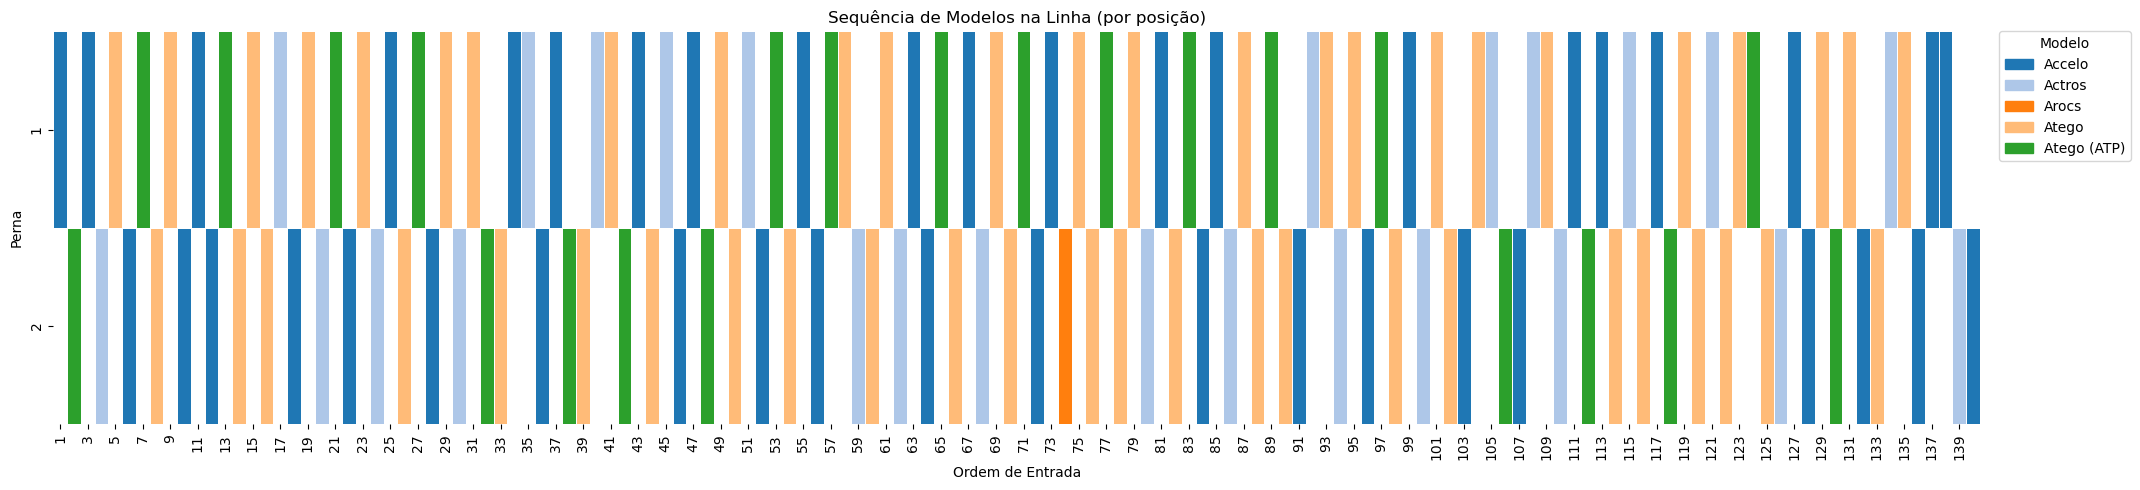

C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-14/log_2025-04-14.csv
📝 PDF salvo em: logs_C3/2025-04-14/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-15
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
6075  2025-04-15 05:47:25  C9511041239 1017        C951104
10438 2025-04-15 05:55:39  C9634251233 2545        C963425
25477 2025-04-15 06:00:49       C9515111278        C951511
8259  2025-04-15 06:06:45   C9511021239 817        C951102
6076  2025-04-15 06:15:05    C96840312 1932        C968403
27630 2025-04-15 06:20:25  C9515441263 3033        C951544
23090 2025-04-15 06:26:58  C9515011268 1721        C951501
10439 2025-04-15 06:44:28  C9511111239 1317        C951111
27631 2025-04-15 06:50:17    C96341412 2653        C963414
8260  2025-04-15 06:55:16       C9515011268        C951501


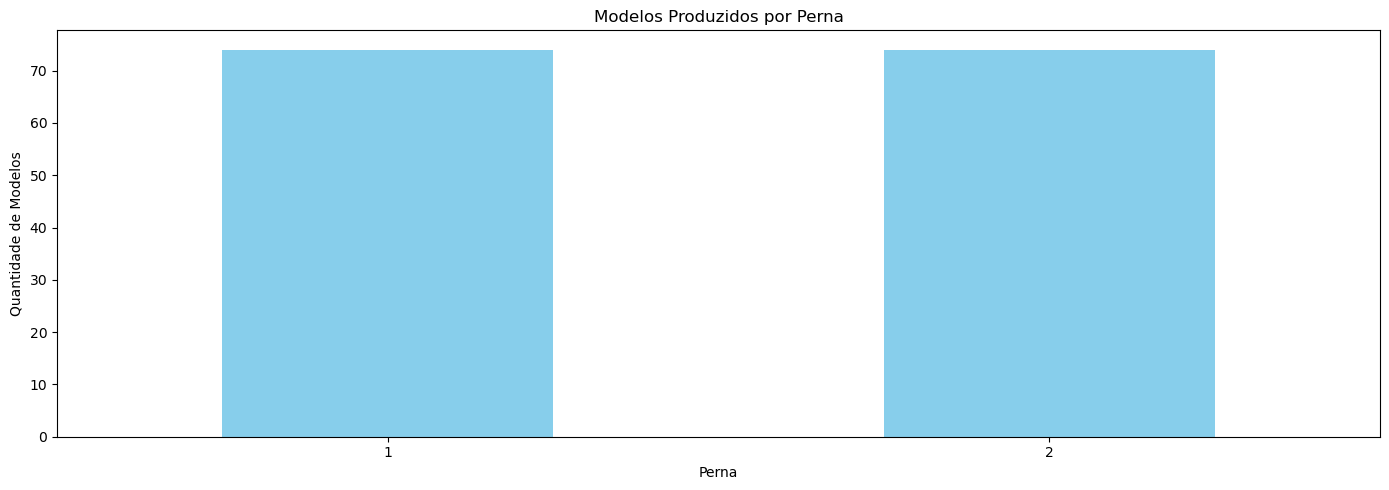

modelo
Atego           58
Accelo          39
Actros          26
Atego (ATP)     23
Arocs            1
Axor (ATP +)     1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_4128\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


                nome        modelo  perna  entrada_total  saida_total
0           Accelo_0        Accelo      1          330.0       3487.0
1          Accelo_10        Accelo      1         3630.0       7255.0
2         Accelo_100        Accelo      1        33330.0      37148.0
3         Accelo_103        Accelo      2        34320.0      38420.0
4         Accelo_106        Accelo      1        35310.0      38614.0
..               ...           ...    ...            ...          ...
143         Atego_93         Atego      2        31020.0      34859.0
144         Atego_94         Atego      1        31350.0      35143.0
145         Atego_96         Atego      1        32010.0      36127.0
146         Atego_97         Atego      2        32340.0      35633.0
147  Axor (ATP +)_54  Axor (ATP +)      1        18416.0      19317.0

[148 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_4128\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


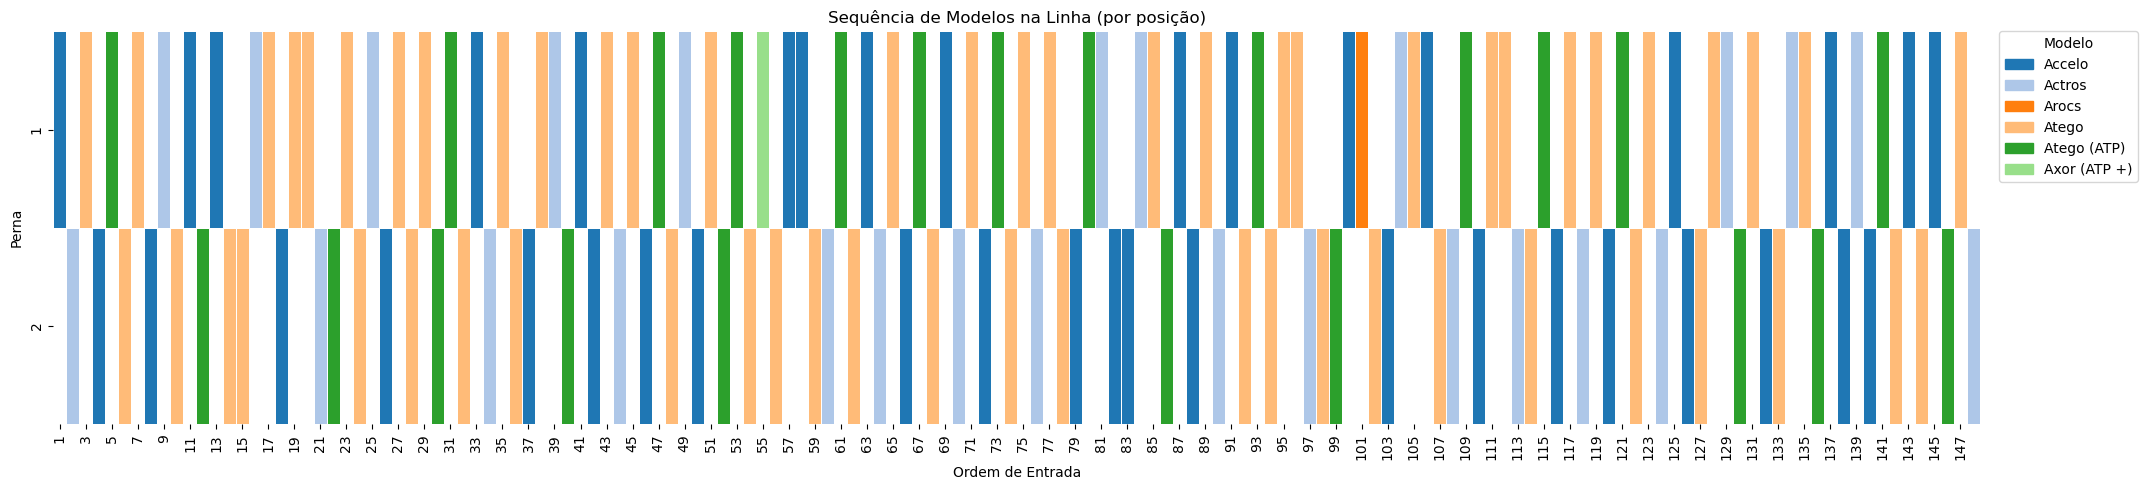

C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-15/log_2025-04-15.csv
📝 PDF salvo em: logs_C3/2025-04-15/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-16
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
23489 2025-04-16 05:47:24  C9511041246 1017        C951104
12803 2025-04-16 06:03:34  C9511111246 1317        C951111
29905 2025-04-16 06:09:58         C96811412        C968114
9910  2025-04-16 06:14:53  C9634251233 2545        C963425
8380  2025-04-16 06:23:54  C9515141236 2730        C951514
17014 2025-04-16 06:33:52   C9511021239 817        C951102
27719 2025-04-16 06:40:30  C9640161215 3351        C964016
4027  2025-04-16 06:46:00       C9515111274        C951511
31993 2025-04-16 06:50:30   C9511021246 817        C951102
27717 2025-04-16 06:56:03  C9634251233 2545        C963425


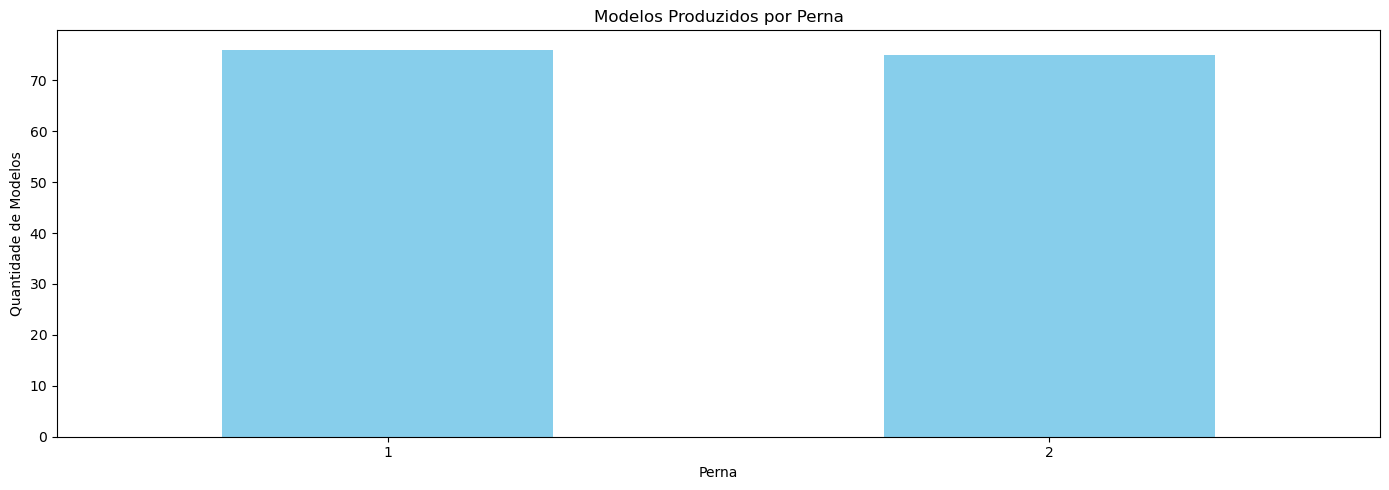

modelo
Atego          54
Accelo         49
Actros         25
Atego (ATP)    22
Arocs           1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_4128\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       3487.0
1      Accelo_1  Accelo      2          660.0       4048.0
2    Accelo_103  Accelo      2        34320.0      38138.0
3    Accelo_105  Accelo      2        34980.0      38809.0
4    Accelo_108  Accelo      1        35970.0      39274.0
..          ...     ...    ...            ...          ...
146    Atego_83   Atego      2        27720.0      31013.0
147    Atego_85   Atego      2        28380.0      31673.0
148    Atego_87   Atego      2        29040.0      32333.0
149    Atego_95   Atego      2        31680.0      35249.0
150    Atego_98   Atego      1        32670.0      36486.0

[151 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_4128\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


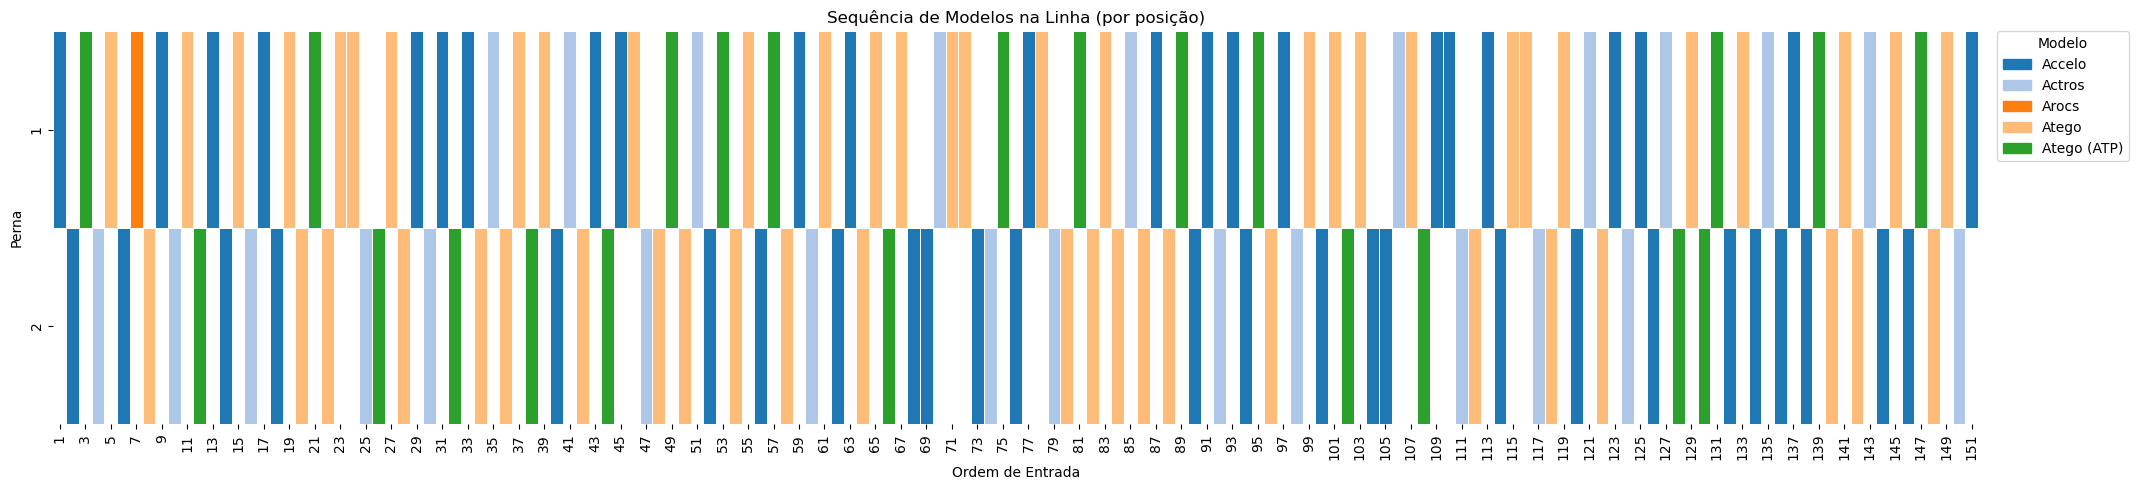

C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_4128\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-16/log_2025-04-16.csv
📝 PDF salvo em: logs_C3/2025-04-16/resumo_simulacao.pdf


In [231]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("sequencias_entrada_linha.xlsx")

# Converte a coluna de data/hora
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'], errors='coerce')

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 10)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.dropna().unique())

# Filtra os dias a partir da data de início e pega os N primeiros
N_DIAS = 5
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:N_DIAS]

print(f"🗓️ Dias selecionados ({N_DIAS} a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_C3", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_C3/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_C3/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # --------- 🔧 AQUI ESTÁ A MUDANÇA IMPORTANTE ---------
    # Filtra dados do dia e ORDENA por Data Entrada Linha (data+hora)
    df_dia = (
        df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia]
        .copy()
        .sort_values('Data Entrada Linha', ascending=True)
    )

    # Extrai os 7 primeiros dígitos do Baumuster (removendo espaços perdidos)
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str.strip().str[:7]

    # Agora a sequência está na ordem correta (crescente por horário daquele dia)
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()
    # ------------------------------------------------------

    # (Opcional) print de conferência
    print("Primeiros registros do dia ordenados:")
    print(df_dia[['Data Entrada Linha', 'Baumuster', 'Baumuster_7dig']].head(10))

    # Simula
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento
    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png", dpi=300, bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png", dpi=300, bbox_inches="tight")
    plt.close(fig2)

    # figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    # for i, fig in enumerate(figs, start=1):
    #     fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
    #     plt.close(fig)
    
    # figs = plot_duracao_media_por_posto(df_log)
    # for i, fig in enumerate(figs, start=1):
    #     fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
    #     plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)

    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf)